# EECS531-A5

This is making the directory directory of the files.

In [1]:
% clear env
close all
clc
% add the src folder into searching path 
if ~exist('./src', 'dir')
    mkdir('./src');
end
addpath('./src');

## Build a simple virtual world

### Add something into the world

This function is creating the points in 3D model. 

In [2]:
%%file ./src/create_points.m
function [points, colors]  = create_points()
    [X, Y, Z] = meshgrid([-0.5, 0, 0.5], [-0.5, 0, 0.5], [-0.5, 0. 0.5]);
    points = [X(:), Y(:), Z(:)];% in these points, x axis is the points in matrix X, y axis is the points in matrix Y, and z axis is the points in the matrix Z
    colors = jet(size(points, 1)); %set the color of points 
end

Created file '/Users/demon_xgg/Downloads/src/create_points.m'.


### Plot the points

This part is plotting all the points. 

In [3]:
%%file ./src/plot_points.m
function plot_points(points, colors, sz, varargin)
    if ~exist('sz', 'var')
        sz = 50;
    end
        
    scatter3(points(:, 1), points(:, 2), points(:, 3), sz, colors, varargin{:});
    % show the circle points with the position, colors. sz means the size of the points.
    daspect([1 1 1])
    % Set the ratio of length, height and height of the coordinate axis to 1
    axis normal
    % Restores the current axis box to full size and cancels all restrictions on the unit scale
end

Created file '/Users/demon_xgg/Downloads/src/plot_points.m'.


### Set up a pair of cameras

This function is setting the parameters of two cameras.  
For the position of cameras, this function using the spherical coordinate system to represent the position of two cameras. 

Here is how we use spherical coordinate system to set the position of camera.
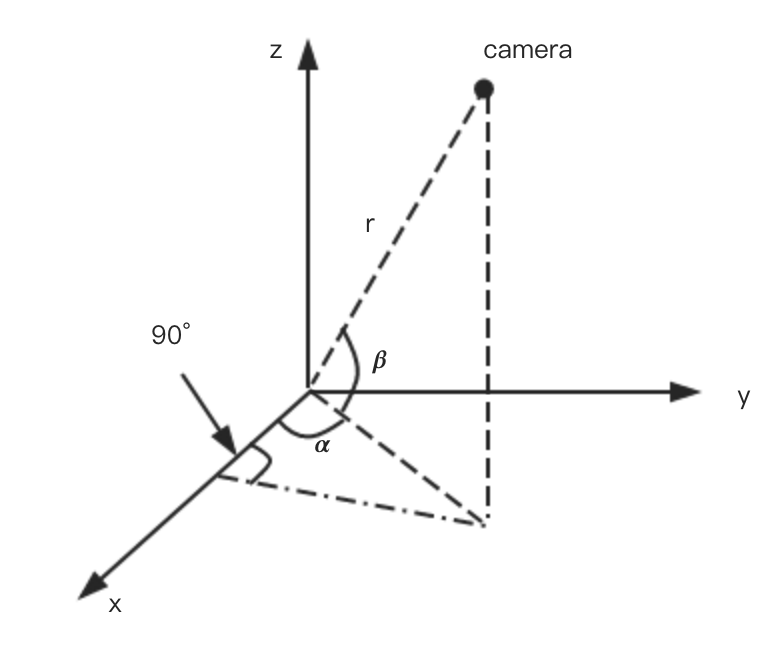  

r means the distance between the camera and the target point(now target point is (0,0,0,)). Angle $\alpha$ and $\beta$ is marked in the picture. 

The formula of calculating the postion of camera is:  
$x = r * cos(\beta)*cos(\alpha)$  
$y = r * cos(\beta)*sin(\alpha)$  
$z = r * sin(\beta)$

focal_length stands for the distance between the camera center and the image plane. Width and height means how many pixels in the horizontal and vertical directions. up means the direction of camera. film_width and film_height means the width and height of the camera's sensor. width/film_width and height/film_height means the unit pixel. 

In [4]:
%%file ./src/preset_cameras.m
function [cam1, cam2]= preset_cameras()

    r     = 5;
    focal_length = 0.06;
    width = 512;
    height =512;
    
    alpha = pi/6;
    beta  = pi/6;
    cam1 = struct('position', [r * cos(beta) * cos(alpha) ,  r* cos(beta) * sin(alpha), r * sin(beta)], ...
        'target', [0, 0, 0], ...
        'up', [0, 0, 1], ....
        'focal_length', focal_length, ...
        'film_width', 0.035, ...
        'film_height',0.035, ...
        'width', width, ...
        'height', height);
        
    alpha = pi/3;
    beta  = pi/6;
    cam2 = struct('position', [r * cos(beta) * cos(alpha) ,  r* cos(beta) * sin(alpha), r * sin(beta)], ...
        'target', [0, 0, 0], ...
        'up', [0, 0, 1], ....
        'focal_length', focal_length, ...
        'film_width', 0.035, ...
        'film_height',0.035, ...
        'width', width, ...
        'height', height);
end

Created file '/Users/demon_xgg/Downloads/src/preset_cameras.m'.


### Plot camera

This funcition is setting the camera coordinate.  
zcam should be the same as the z axis and we need to reserve the direction.  
Then using zcam to decide the x axis and y axis of camera.   
After setting the axises, normalize them to unit vector. The position of camera is the origin point of the coordinate system. 

In [5]:
%%file ./src/camera_coordinate_system.m
function [xcam, ycam, zcam, origin] = camera_coordinate_system(cam)
    % the axis of camera coordinate system
    % principal axis
    zcam = cam.target - cam.position;

    % x aixs should pend to principal axis and up direction
    xcam = cross(zcam, cam.up);

    % y axis should pend to principal axis and principal axis
    ycam = cross(zcam, xcam);

    % normalize to unit vector
    zcam = zcam ./ norm(zcam);
    xcam = xcam ./ norm(xcam);
    ycam = ycam ./ norm(ycam);
    
    origin = cam.position;
end

Created file '/Users/demon_xgg/Downloads/src/camera_coordinate_system.m'.


This part is using the camera coordinate to confirm the view of camera.   
x means the width of the area that the camera can get.  
y means the width of the area that the camera can get.    
x is comming from the formula of similar triangles.  
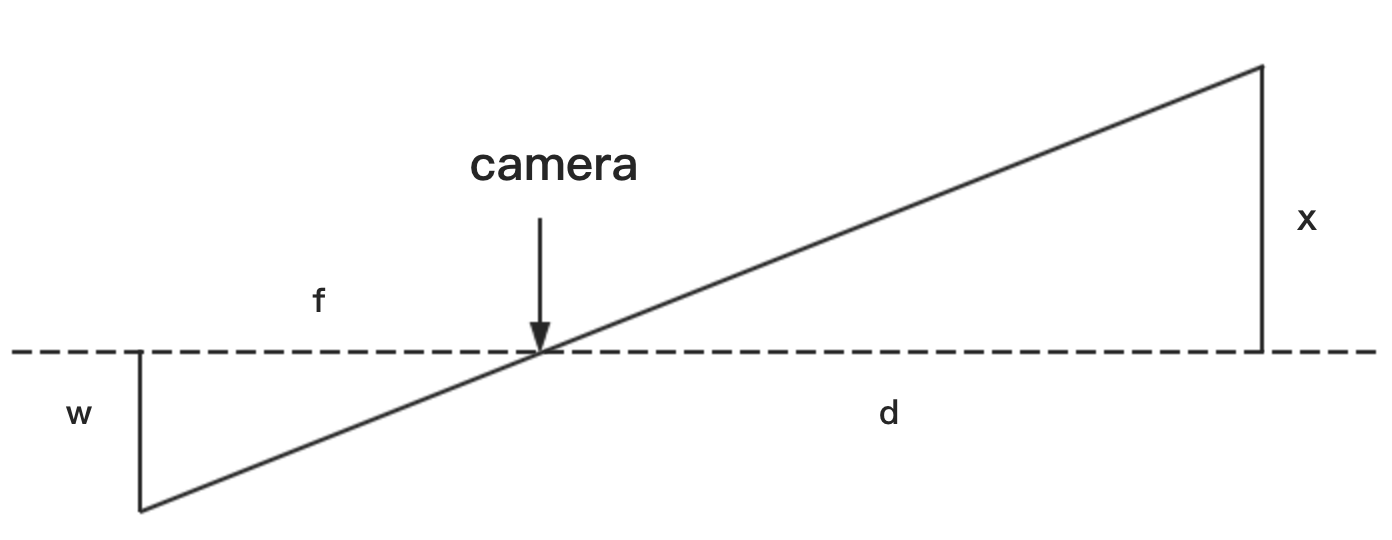

$\frac{f}{d} = \frac{w}{x}$  
  
  
$x = \frac{w*d}{f}$  
  
Because from the center, we should add half width and half height, that is the reason multiply 0.5 

In [6]:
%%file ./src/plot_camera.m
function plot_camera(cam, label, color)

% parse inputs
if ~isempty(label)
   % add label
    text(cam.position(1), cam.position(2), cam.position(3), label);
end

if ~exist('color', 'var')
    color = [0.75, 0.75, 0.75];
end

% compute the camera coordinate system
[xcam, ycam, zcam, origin] = camera_coordinate_system(cam);

% the four corners of the rectangle 
% on the plane through focal points
d = norm(cam.target-cam.position);
% d is the r in the previous part 

x = 0.5 * cam.film_width * d / cam.focal_length;
y = 0.5 * cam.film_height * d / cam.focal_length;

% I think these four points are the corners.
P1 = origin + x * xcam + y * ycam + d * zcam;
P2 = origin + x * xcam - y * ycam + d * zcam;
P3 = origin - x * xcam - y * ycam + d * zcam;
P4 = origin - x * xcam + y * ycam + d * zcam;

% function to draw a line segment (p1, p2)
connect=@(p1, p2) plot3([p1(1), p2(1)], [p1(2), p2(2)], [p1(3), p2(3)], ...
    'color', color);

% plot line connect camera and target
connect(cam.position, cam.target);

% plot line connect P1, P2, P3, P4
patch('Faces', [1, 2, 3, 4, 1], 'Vertices', [P1;P2;P3;P4], ...
   'EdgeColor', color, 'Facecolor', color, 'Facealpha', 0.1);
% connect(P1, P2);
% connect(P2, P3);
% connect(P3, P4);
% connect(P4, P1);

% plot line connect camera to P1, P2, P3, P4
connect(cam.position, P1);
connect(cam.position, P2);
connect(cam.position, P3);
connect(cam.position, P4);


end

Created file '/Users/demon_xgg/Downloads/src/plot_camera.m'.


# Show the virtual world

In [7]:
[points, colors] = create_points();
[cam1, cam2]= preset_cameras();
% disp('points : ') ; disp(points);
% disp('colors : ') ; disp(colors);
disp('camera 1: '); disp(cam1);
disp('camera 2: ');  disp(cam2);

camera 1: 
        position: [3.7500 2.1651 2.5000]
          target: [0 0 0]
              up: [0 0 1]
    focal_length: 0.0600
      film_width: 0.0350
     film_height: 0.0350
           width: 512
          height: 512

camera 2: 
        position: [2.1651 3.7500 2.5000]
          target: [0 0 0]
              up: [0 0 1]
    focal_length: 0.0600
      film_width: 0.0350
     film_height: 0.0350
           width: 512
          height: 512



This function is deletting some parameters. In matlab, set(gca,) f unction means deletting somethings. In order the show the view of camera better, this function deletes the up,position and target of camera, so the result only have the view and some lines to show the view is looked through by the camera.

In [8]:
%%file ./src/lookthrough.m
function lookthrough(cam)
    set(gca, 'cameraUpVector', cam.up);
    set(gca, 'cameraPosition', cam.position);
    set(gca, 'cameraTarget', cam.target);
end

Created file '/Users/demon_xgg/Downloads/src/lookthrough.m'.


Plot the result.

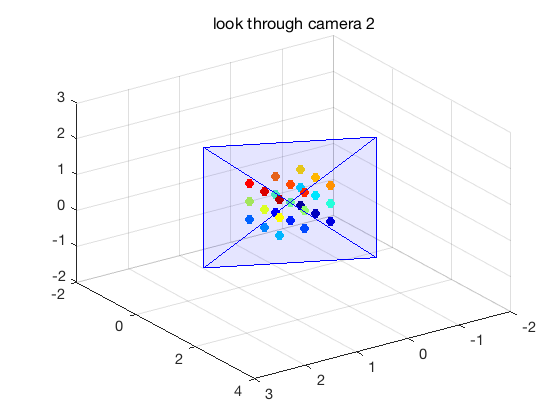

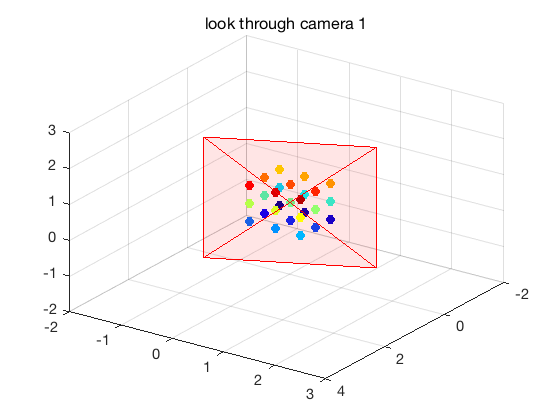

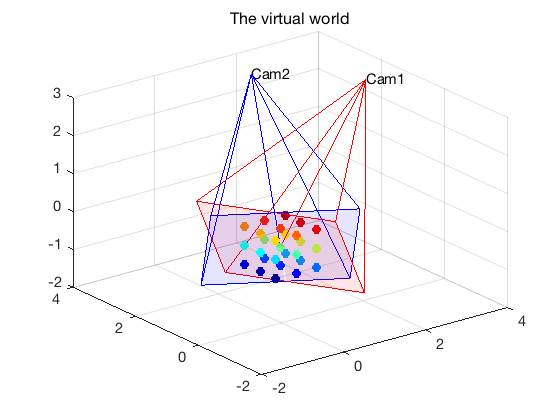

In [9]:
figure;

plot_points(points, colors, 50, 'filled'); 
hold on; 
plot_camera(cam1, 'Cam1', [1 0 0]);
hold on; 
plot_camera(cam2, 'Cam2', [0 0 1]); 
title('The virtual world')

figure;
plot_points(points, colors, 50, 'filled'); 
hold on; 
plot_camera(cam1, '', [1 0 0]);
lookthrough(cam1);
title('look through camera 1')

figure;
plot_points(points, colors, 50, 'filled'); 
hold on; 
plot_camera(cam2, '', [0 0 1]);
lookthrough(cam2);
title('look through camera 2')

## Camera Model

(See slide pages 1-8)

### Euclidean transformation matrix

(See slide page 6)

There are two matrixes in this function, the first one is a rotation matrix, I think the function of this matrix is transfor the coordinate from world coordinate to camera coordinate.  
I out put the matrix R, so the matrix should be described as:
$$R = \begin{equation}       
\left(                 
  \begin{array}{ccc}   
    xcam1 & ycam1 & zcam1\\  
    xcam2 & ycam2 & zcam2\\
    xcam3 & ycam3 & zcam3\\
  \end{array}
\right)                
\end{equation}$$  
  
For matrix M, according to the formula, the matrix should be: 
$$M =\begin{equation}       
\left(                 
  \begin{array}{ccc}   
    xcam1 & ycam1 & zcam1\\  
    xcam2 & ycam2 & zcam2\\
    xcam3 & ycam3 & zcam3\\
    -(o_x*xcam1+o_x*xcam2+o_x*xcam3) & 
    -(o_y*ycam1+o_y*ycam2+o_y*ycam3) & 
    -(o_z*zcam1+o_z*zcam2+o_z*zcam3)\\
  \end{array}
\right)                
\end{equation}$$


In [10]:
%%file ./src/ExtrinsicsMtx.m
function M = ExtrinsicsMtx(cam)
[xcam, ycam, zcam, origin] = camera_coordinate_system(cam);
disp("origin")
disp(origin)
% rotation matrix
R = [xcam(:) ycam(:) zcam(:)];
M = [R; -origin * R];
disp("R")
disp(R)
disp("M")
disp(M)
end

Created file '/Users/demon_xgg/Downloads/src/ExtrinsicsMtx.m'.


### Camera calibration matrix

(See slide page 4)

$$ c_x = \frac{width+1}{2}, 
c_y = \frac{height+1}{2},\\   
f_x = focal\_length*\frac{width}{film\_width},    
fy = focal\_length*\frac{height}{film\_height}$$  
The principal point $(c_x,c_y)$, which is the point where the
optic axis intersects the image plane.

$$K = \begin{equation}       
\left(                 
  \begin{array}{ccc}   
    f_x & 0 & 0\\  
    0 & f_y & 0\\
    c_x & c_y & 1\\
  \end{array}
\right)                
\end{equation}$$
But I see the K matrix in the slides is:
$$K = \begin{equation}       
\left(                 
  \begin{array}{ccc}   
    f_x & 0   & c_x\\  
    0   & f_y & c_y\\
    0   & 0   & 1\\
  \end{array}
\right)                
\end{equation}$$  
And I don't see any transfer, I don't know why K is different in demo.

In [11]:
%%file ./src/IntrinsicsMtx.m
function K = IntrinsicsMtx(cam)
    cx = (cam.width+1) * 0.5;
    cy = (cam.height+1) * 0.5;

    fx = cam.focal_length * cam.width / cam.film_width;
    fy = cam.focal_length * cam.height / cam.film_height;

    K = [fx, 0, 0; 0, fy, 0; cx, cy, 1];
    disp("K")
    disp(K)
end


Created file '/Users/demon_xgg/Downloads/src/IntrinsicsMtx.m'.


### Camera matrix

(See slide page 7)

P is the 3 × 4 projection matrix from Euclidean 3-space.  
K provides the transformation between an image point and a ray in Euclidean 3-space.

In [12]:
%%file ./src/CameraMtx.m
function P = CameraMtx(cam)       
    M = ExtrinsicsMtx(cam);
    K = IntrinsicsMtx(cam);
    P = M * K;
end

Created file '/Users/demon_xgg/Downloads/src/CameraMtx.m'.


### Generate the image pair

This funtion is transforming the 3D points to 2D points.  
The camera model for perspective projection is a linear map between
homogeneous point coordinates

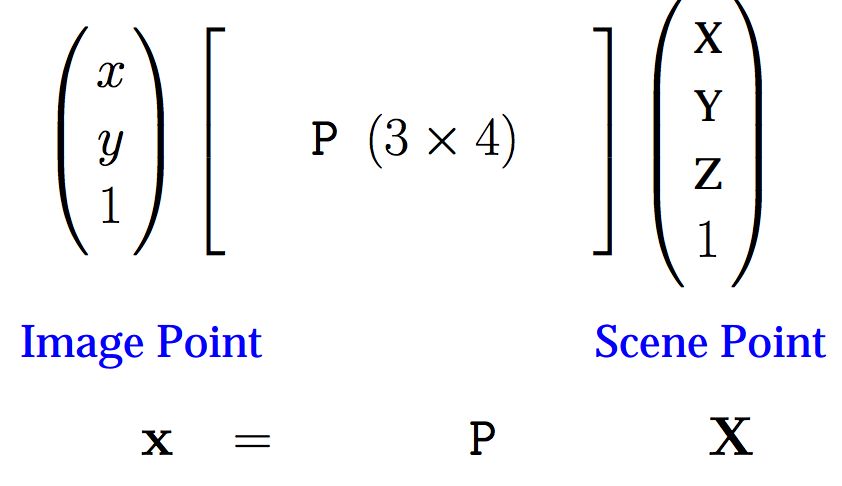

In this picture, x is 2D points, X is 3D points. 

In [13]:
%%file ./src/world2image.m
function points2d = world2image(cam, points3d) 
    P = CameraMtx(cam);
    pt = [reshape(points3d, [], 3) ones(numel(points3d)/3, 1)]; 
    pt = pt * P;
    x = pt(:, 1) ./ pt(:, 3);
    y = pt(:, 2) ./ pt(:, 3);
    points2d = [x y];
end

Created file '/Users/demon_xgg/Downloads/src/world2image.m'.


This function is setting the color.  
The first loop is setting color for each point.  
x = points2d(i, 1); and y = points2d(i, 2); will pick the two columns of matrix points2d in order.  

(x,y) will decide a point. But if we use this point to show the result, the point is too small. Because a point is only a pixel.  
This function will select a circle with the radius R of center point (x,y). Then coloring the circle with fixed color. So the point will be colored in to a bigger area, it is a better way to show the point.  
Of coutse, bigger R, bigger circle.  
I change the dilate into 10, the result shows bigger circle. 

r1 = max(1, floor(y-R));  
r2 = min(h, ceil(y+R));  
c1 = max(1, floor(x-R));  
c2 = min(w, ceil(x+R));  
These four sentences show how to selected the color circle and forbidden the circle will beyond the range. 

In [14]:
%%file ./src/setcolor.m
function Io = setcolor(I, points2d, colors, R)
% Size of I have to be equal to the size of image 
disp(points2d)
Io = I;
h  =  size(I, 1);
w  =  size(I, 2);
np = size(points2d, 1); % number of pixels

for i=1:np
    x = points2d(i, 1);
    y = points2d(i, 2);
    
    r1 = max(1, floor(y-R));
    r2 = min(h, ceil(y+R));
    c1 = max(1, floor(x-R));
    c2 = min(w, ceil(x+R));
    
    % fill an circle area
    for r = r1:r2
        for c=c1:c2
            if (r-y).^2 + (c-x).^2 < R.^2
                Io(r, c, :) = colors(i, :);
            end
        end
    end           
end
end

Created file '/Users/demon_xgg/Downloads/src/setcolor.m'.


666
origin
    3.7500    2.1651    2.5000

R
   -0.5000    0.4330   -0.7500
    0.8660    0.2500   -0.4330
         0   -0.8660   -0.5000

M
   -0.5000    0.4330   -0.7500
    0.8660    0.2500   -0.4330
         0   -0.8660   -0.5000
   -0.0000         0    5.0000

K
  877.7143         0         0
         0  877.7143         0
  256.5000  256.5000    1.0000

origin
    2.1651    3.7500    2.5000

R
   -0.8660    0.2500   -0.4330
    0.5000    0.4330   -0.7500
         0   -0.8660   -0.5000

M
   -0.8660    0.2500   -0.4330
    0.5000    0.4330   -0.7500
         0   -0.8660   -0.5000
         0         0    5.0000

K
  877.7143         0         0
         0  877.7143         0
  256.5000  256.5000    1.0000

  229.0015  270.2493
  295.5095  290.2832
  367.3423  311.9212
  186.9745  305.9552
  256.5000  328.8927
  332.0065  353.8033
  138.7568  346.9208
  211.4890  373.4420
  290.9817  402.4284
  227.7720  202.8928
  297.3239  221.1454
  372.7142  240.9303
  183.6425  235.4679
  256.5

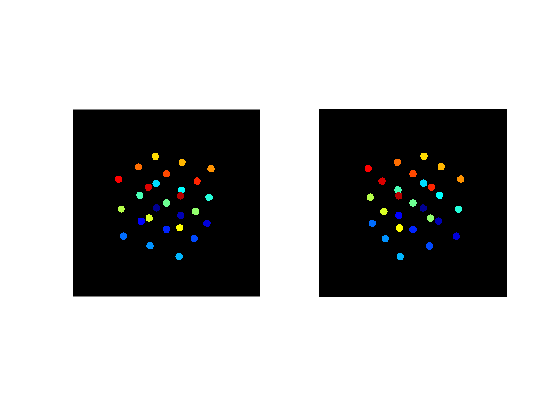

In [15]:
dilate = 10;
disp("666")
px1 = world2image(cam1, points);
px2 = world2image(cam2, points);
I1 = setcolor( zeros(cam1.height, cam1.width, 3), px1, colors, dilate);
I2 = setcolor( zeros(cam2.height, cam2.width, 3), px2, colors, dilate);

figure
subplot(1,2,1); imshow(I1);
subplot(1,2,2); imshow(I2);


## Trianglation
Given the cameras and point pairs, reconstruct the 3D positions in world coordinates of the point pairs.

### Linear triangluation method

(See slide page 51 and Hartley and Zisserman chapter 12.2 and A5.3)

In this part, the functions is restructing the 3D points.  
The first step is generating a matrix. The size of this matrix is $(points *3)$. 

Second step, we will get a form equations $Af = 0$.   
Then we need to take a SVD: $A = UDV^T$    
The last column of V will be the solution.  
Minimizes ||Af|| subject to ||f|| = 1.

SVD Method:  
1. SVD: $F = UDV^T$
2. U and V are orthogonal, D =diag(r,s,t)
3. r >= s >= t
4. Set F^'= Udiag(r,s,0)V^T
5. Resulting F^' is singular
6. Minimizes the Frobenius norm of F-F^'
7. F^' is the "closest" singular matrix to F

The core idea is:
For Linear solution : Solve $Af = 0$ to find F.

In [16]:
%%file triangulate.m
function points3d = triangulate(points1, points2, P1, P2)
    np = size(points1, 1);
    points3d = zeros(np, 3);
    
    % iterate over point paris
    for i=1:np
        points3d(i, :)= triangulationOnePoint(points1(i, :)', points2(i, :)', P1', P2');
    end
end

function point3d = triangulationOnePoint(point1, point2, P1, P2)
% construct A
A = zeros(4, 4);
A(1:2,:) = point1 * P1(3,:) - P1(1:2,:);
A(3:4,:) = point2 * P2(3,:) - P2(1:2,:);

% solve the optimization problem: min_x ||Ax|| s.t ||x|| = 1
[~,~,V] = svd(A);
X = V(:, end);
X = X/X(end);

% homogenous -> inhomogenous
point3d = X(1:3)';
end

Created file '/Users/demon_xgg/Downloads/triangulate.m'.


origin
    3.7500    2.1651    2.5000

R
   -0.5000    0.4330   -0.7500
    0.8660    0.2500   -0.4330
         0   -0.8660   -0.5000

M
   -0.5000    0.4330   -0.7500
    0.8660    0.2500   -0.4330
         0   -0.8660   -0.5000
   -0.0000         0    5.0000

K
  877.7143         0         0
         0  877.7143         0
  256.5000  256.5000    1.0000

origin
    2.1651    3.7500    2.5000

R
   -0.8660    0.2500   -0.4330
    0.5000    0.4330   -0.7500
         0   -0.8660   -0.5000

M
   -0.8660    0.2500   -0.4330
    0.5000    0.4330   -0.7500
         0   -0.8660   -0.5000
         0         0    5.0000

K
  877.7143         0         0
         0  877.7143         0
  256.5000  256.5000    1.0000

origin
    3.7500    2.1651    2.5000

R
   -0.5000    0.4330   -0.7500
    0.8660    0.2500   -0.4330
         0   -0.8660   -0.5000

M
   -0.5000    0.4330   -0.7500
    0.8660    0.2500   -0.4330
         0   -0.8660   -0.5000
   -0.0000         0    5.0000

K
  877.7143         0

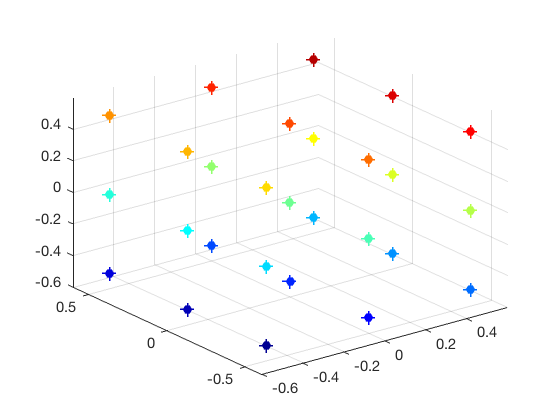

In [18]:
[points, colors] = create_points();
P1 = CameraMtx(cam1);
P2 = CameraMtx(cam2);
px1 = world2image(cam1, points);
px2 = world2image(cam2, points);
rec = triangulate(px1, px2, P1, P2);

scatter3(points(:, 1), points(:, 2), points(:, 3), 100, colors, '+');
hold on
scatter3(rec(:, 1), rec(:, 2), rec(:, 3), 50, colors, 'filled');
xlim([-0.6, 0.6]);
ylim([-0.6, 0.6]);
zlim([-0.6, 0.6]);

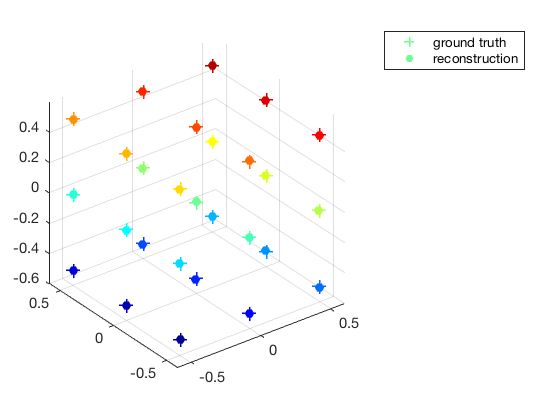

In [19]:
% add noise
sigma = 0.75;
px1 = px1+sigma*rand(size(px1));
px2 = px2+sigma*rand(size(px2));
rec = triangulate(px1, px2, P1, P2);
scatter3(points(:, 1), points(:, 2), points(:, 3), 100, colors, '+');
hold on
scatter3(rec(:, 1), rec(:, 2), rec(:, 3), 50, colors, 'filled', 'o');
xlim([-0.6, 0.6]);
ylim([-0.6, 0.6]);
zlim([-0.6, 0.6]);
legend({'ground truth', 'reconstruction'})
daspect([1, 1, 1])